<div align="left">
<img align="left" src="datasciencebowl.png" >
<div> <b> Kaggle </b></div>
<div> 2018 Data Science Bowl </div>
<div> Pedro D. Marrero Fernandez</div>
<div> https://www.kaggle.com/c/data-science-bowl-2018/discussion/47770 </div>
<div> :), :(, :/</div>
</div>

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import csv
import scipy.misc
import math 

from deep.datasets import imageutl as imutl
from deep.datasets import utility as utl
from deep.datasets import weightmaps 
from deep import visualization as view

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
pathdataset = '../db'
namedataset = 'databoewl'
pathname = os.path.join(pathdataset, namedataset);

base_folder = pathname
sub_folder =  imutl.testfile
folders_image='images'

dataloader = imutl.dsxbImageProvide.create(
    base_folder, 
    sub_folder, 
    folders_image, 
    )

print(len(dataloader))
print(':)!!!')

65
:)!!!


(256, 256, 3) 1 79


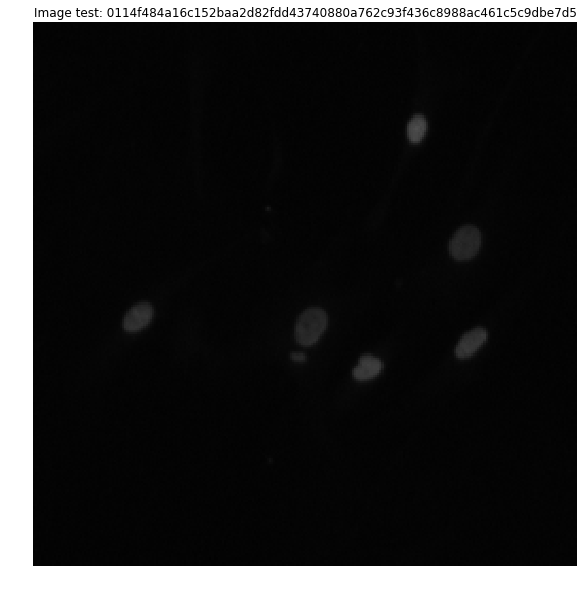

In [3]:

image = dataloader[ 0 ]

print(  image.shape, np.min(image), np.max(image) )

plt.figure( figsize=(10,10))
plt.imshow( image )
plt.title('Image test: {}'.format( dataloader.getid() ))
plt.axis('off')
plt.show()


In [4]:
def create_input(data, fovnet , mode = 'mirror'):
    
    mH,mW = data.shape[:2]
    h,w = fovnet[:2]

    cx = mW//w; padx = (w - mW%w)   
    cy = mH//h; pady = (h - mH%h)   
    border = pady, padx

    borderL = border[0]//2 
    borderR = np.ceil(border[0]/2).astype(np.uint8)     
    borderT = border[1]//2 
    borderB = np.ceil(border[1]/2).astype(np.uint8)
        
    paddedFullImage = np.zeros( (data.shape[0] + border[0], data.shape[1] + border[1], data.shape[2] ) );
    paddedFullImage[ borderL:(borderL+data.shape[0]), borderT:(borderT+data.shape[1]), : ] = data;
    
    if mode == 'mirror':
        
        xpadL  = borderL;
        xfromL = borderL+1;
        xtoL   = borderL+data.shape[0];    
        
        xpadR  = borderR;
        xfromR = borderR+1;
        xtoR   = borderR+data.shape[0];
        
        paddedFullImage[:xfromL,:,:] = paddedFullImage[ xfromL-1:xfromL+xpadL,:,:][::-1,:,:];
        paddedFullImage[xtoL:,:,:] = paddedFullImage[xtoL-xpadR:xtoL, :,:][::-1,:,:] ;

        ypadT  = borderT;
        yfromT = borderT+1;
        ytoT   = borderT+ data.shape[1];
        
        ypadB  = borderB;
        yfromB = borderB+1;
        ytoB   = borderB+ data.shape[1];
        
        paddedFullImage[:, :yfromT,:] = paddedFullImage[ :, yfromT-1:yfromT+ypadT,:][:,::-1,:];
        paddedFullImage[:, ytoT:,:] = paddedFullImage[ :, ytoT-ypadB:ytoT, :][:,::-1,:];
    
    
    return paddedFullImage, border
    

def sliding_windows( data, sizewnd=(572,572) ):
    h,w = data.shape[:2]
    ny, nx = h//sizewnd[0], w//sizewnd[1]    
    for i in range(ny):
        for j in range(nx):
            inix = j*sizewnd[1] ;iniy = i*sizewnd[0]
            yield( iniy, inix, data[iniy:iniy+sizewnd[0], inix:inix+sizewnd[1],:] )
            
       
    


(256, 256, 3)
[ 22.  22.]
[412 412]
[228 228]
1.0
0 0 (412, 412, 3)
(412, 412, 3)


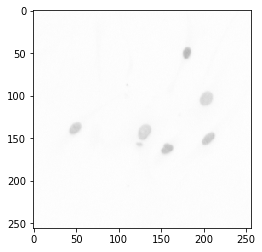

In [11]:

image = dataloader[ 0 ]

print(image.shape)
imsize = (228,228) #(196,196) # 
d4a_size = 0
downsampleFactor = 16,
padInput = (((d4a_size*2 +2 +2)*2 +2 +2)*2 +2 +2)*2 +2 +2,
padOutput = ((((d4a_size -2 -2)*2-2 -2)*2-2 -2)*2-2 -2)*2-2 -2,

d4a_size = np.ceil( (np.array([imsize[0], imsize[1]]) - padOutput)/downsampleFactor  )    
input_size  = (downsampleFactor*d4a_size + padInput).astype(int);
output_size = (downsampleFactor*d4a_size + padOutput).astype(int); 

print(d4a_size)
print(input_size)
print(output_size)

image_t, border = create_input( image, input_size )
print(image_t.shape[0]/input_size[0])

image_r = np.zeros( (image_t.shape[0], image_t.shape[1], 3) )
for (i,j, image_c ) in sliding_windows( image_t, input_size ):
    print(i,j, image_c.shape)
    image_r[i:(i+1)*input_size[0],j:(j+1)*input_size[1],:] = image_c

    
print(image_r.shape)
image_r = image_t[ (border[0]//2):(border[0]//2)+image.shape[0], (border[1]//2):(border[1]//2) + image.shape[1], : ]    



plt.figure()
plt.imshow( image_r )
plt.show()



In [24]:

def tiled_forward(data, opts ):
    
    #n_tiles = opts['n_tiles']
    n_tilesx = 4
    n_tilesy = 4
    
    padOutput = opts['padOutput']
    padInput  = opts['padInput']
    downsampleFactor = opts['downsampleFactor']
    padding = opts['padding']
    
    imsize = np.array(data.shape[:2])
    d4a_size = np.ceil( (np.array([np.ceil( imsize[0]/n_tilesx ) , np.ceil( imsize[1]/n_tilesy ) ]) - padOutput)/downsampleFactor  )    
    input_size = downsampleFactor*d4a_size + padInput;
    output_size = downsampleFactor*d4a_size + padOutput;        
    border = (np.round(input_size-output_size)//2);
    
    border = border.astype(int)
    input_size = input_size.astype(int)
    output_size = output_size.astype(int)
                         
    paddedFullImage = np.zeros( (data.shape[0] + 2*border[0], data.shape[1] + 2*border[1], data.shape[2] ) );
    paddedFullImage[ border[0]:border[0]+data.shape[0], border[1]:border[1]+data.shape[1], : ] = data;
       
    if padding == 'mirror':
        
        xpad  = border[0];
        xfrom = border[0]+1;
        xto   = border[0]+data.shape[0];        
        paddedFullImage[:xfrom,:,:] = paddedFullImage[ xfrom-1:xfrom+xpad,:,:][::-1,:,:];
        paddedFullImage[xto:,:,:] = paddedFullImage[xto-xpad:xto, :,:][::-1,:,:] ;

        ypad  = border[1];
        yfrom = border[1]+1;
        yto   = border[1]+ data.shape[1];        
        paddedFullImage[:, :yfrom,:] = paddedFullImage[ :, yfrom-1:yfrom+ypad,:][:,::-1,:];
        paddedFullImage[:, yto:,:] = paddedFullImage[ :, yto-ypad:yto, :][:,::-1,:];
        
            
    nClasses = 3
    scores = np.zeros( (data.shape[0],data.shape[1], nClasses) );
    for yi in range(n_tilesy):
        for xi in range(n_tilesx):
        
            print(yi,xi)
                
            paddedInputSlice = np.zeros( (input_size[0], input_size[1], data.shape[2]) )
            validReg_x = min( input_size[0], paddedFullImage.shape[0] - xi*output_size[0] )
            validReg_y = min( input_size[1], paddedFullImage.shape[1] - yi*output_size[1] )

            paddedInputSlice[:validReg_x, :validReg_y] = paddedFullImage[xi*output_size[0]:xi*output_size[0]+validReg_x, yi*output_size[1]:yi*output_size[1]+validReg_y,:]


            scoreSlice = np.zeros( (output_size[0],output_size[1],nClasses) )
            #scores_caffe = caffe('forward', {fliplr(paddedInputSlice)});
            #scoreSlice = scoreSlice+fliplr(scores_caffe{1});
            #scores_caffe = caffe('forward', {flipud(paddedInputSlice)});
            #scoreSlice = scoreSlice+flipud(scores_caffe{1});
            #scores_caffe = caffe('forward', {flipud(fliplr(paddedInputSlice))});
            #scoreSlice = scoreSlice+flipud(fliplr(scores_caffe{1}));
            #scoreSlice = scoreSlice/4;


            validReg_x = min(output_size[0], scores.shape[0] - xi*output_size[0] );
            validReg_y = min(output_size[1], scores.shape[1] - yi*output_size[1] );        
            scores[xi*output_size[0]:xi*output_size[0]+validReg_x, 
                   yi*output_size[1]:yi*output_size[1]+validReg_y,:] = scoreSlice[:validReg_x,:validReg_y,:];

            print(paddedInputSlice.shape)
            plt.figure( figsize=(5,5) )
            plt.imshow(paddedInputSlice)
            plt.show()
    
    
    return scores
    



0 0
(252, 316, 3)


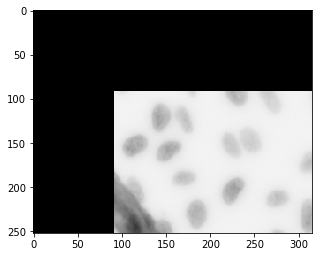

0 1
(252, 316, 3)


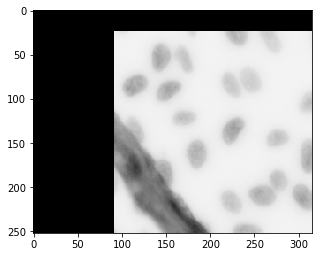

0 2
(252, 316, 3)


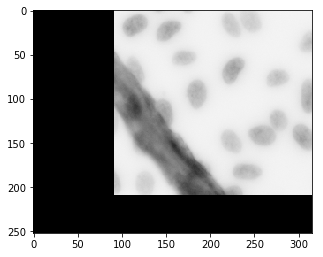

0 3
(252, 316, 3)


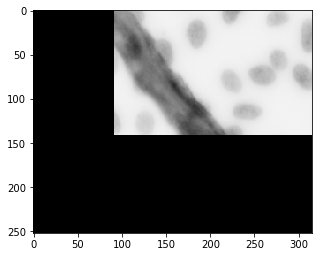

1 0
(252, 316, 3)


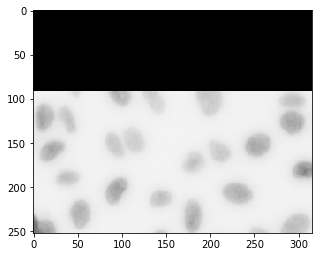

1 1
(252, 316, 3)


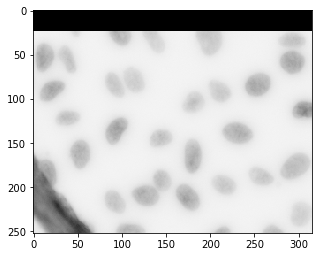

1 2
(252, 316, 3)


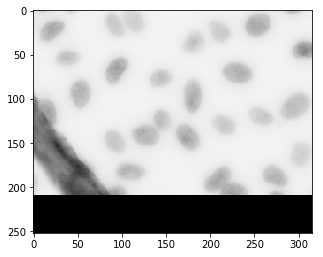

1 3
(252, 316, 3)


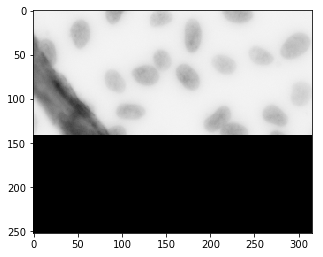

2 0
(252, 316, 3)


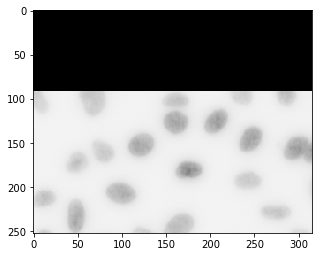

2 1
(252, 316, 3)


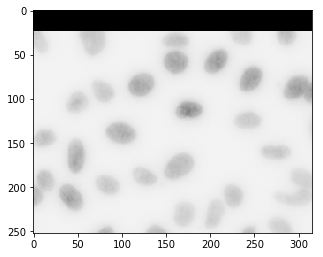

2 2
(252, 316, 3)


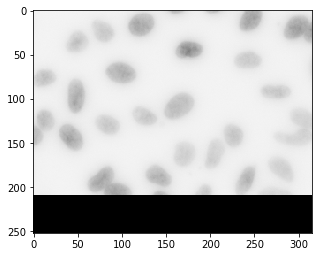

2 3
(252, 316, 3)


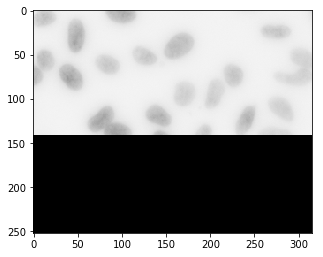

3 0
(252, 316, 3)


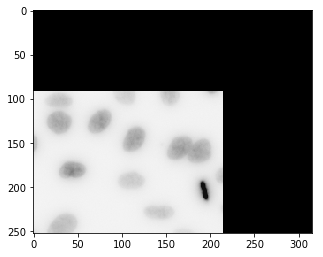

3 1
(252, 316, 3)


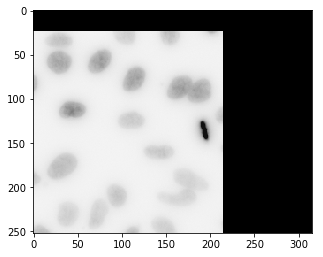

3 2
(252, 316, 3)


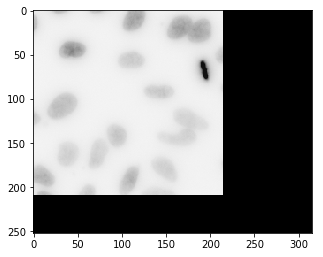

3 3
(252, 316, 3)


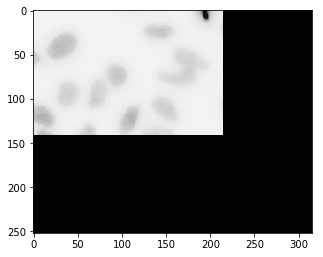

(253, 519, 3)
(253, 519, 3)


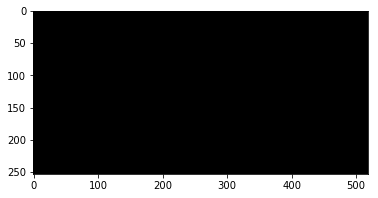

In [27]:

image = dataloader[ 1 ]
image = image.transpose((1,0,2))

nTiles = 4
d4a_size = 0

opts = {
    'n_tiles': nTiles,
    'padding': None, # 'mirror',
    'downsampleFactor': 16,
    'padInput': (((d4a_size*2 +2 +2)*2 +2 +2)*2 +2 +2)*2 +2 +2,
    'padOutput': ((((d4a_size -2 -2)*2-2 -2)*2-2 -2)*2-2 -2)*2-2 -2,
    'average_mirror': True
    }


score = tiled_forward(image, opts)

print(score.shape)
print(image.shape)
plt.imshow(score)
plt.show()




# Torch forward

In [3]:

import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as tfun
import cv2
from skimage import color
import skfmm

from deep import netmodels as nnmodels
from deep.datasets import imageutl as imutl


In [4]:
PATHDATASET = '../db'
NAMEDATASET = 'databoewl'
PATHMODEL = 'netruns/exp_net_unet_003'
#PATHMODEL = 'netruns/exp_net_unet_002/models'
NAMEMODEL = 'model_best.pth.tar'
RLNAME = 'test_masks.csv'
NUMITER = 5

In [5]:
base_folder = os.path.join(PATHDATASET, NAMEDATASET);
pathnamemodel = os.path.join(PATHMODEL, NAMEMODEL)
bcuda = torch.cuda.is_available()

sub_folder =  imutl.testfile
folders_image='images'

print('>> Load dataset ...')

# load data
dataloader = imutl.dsxbImageProvide.create(
    base_folder, 
    sub_folder, 
    folders_image, 
    )

numiter = NUMITER #dataloader.num;

print('>> Load dataset ready ...')
print('>> Total image: ', len(dataloader))


>> Load dataset ...
>> Load dataset ready ...
>> Total image:  65


In [6]:
print('>> Load model ...')

# Setup Model
if bcuda: model = torch.load( pathnamemodel )
else: model = torch.load( pathnamemodel, map_location=lambda storage, loc: storage )
num_classes = model['num_classes']

net = nnmodels.unet( n_classes = num_classes )
if bcuda: net.cuda()

net.load_state_dict(model['state_dict'])

print('>> Model loader ready ...')

>> Load model ...
>> Model loader ready ...


In [91]:
#down1.conv.conv1.0.weight
#model['state_dict']

In [7]:
print('>> Evaluating')
net.eval()

>> Evaluating


UNet(
  (down1): unetDown(
    (conv): unetConv2(
      (conv1): Sequential(
        (0): Conv2d (1, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
      )
    )
    (down): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (down2): unetDown(
    (conv): unetConv2(
      (conv1): Sequential(
        (0): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
      )
    )
    (down): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (down3): unetDown(
    (conv): unetConv2(
      (conv1): Sequential(
        (0): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1))
  

In [8]:
def forward( net, image_in ):

    image_proc = image_in[:, :, :]
    image_proc = image_proc.astype(float)
    
    # NHWC -> NCHW
    image_proc = image_proc.transpose(2, 0, 1)
    image_proc = image_proc[np.newaxis,...]
    image_proc = torch.from_numpy(image_proc).float()

    if torch.cuda.is_available():
        net.cuda(0)
        images_torch = Variable(image_proc.cuda(0), volatile=True )
    else:
        images_torch = Variable(image_proc)

    # fordward
    outputs = net(images_torch)
    pred = tfun.softmax(outputs).data.cpu().numpy()
        
    pred = pred.transpose(2,3,1,0)
    pred = pred[...,0]
    
    return pred


def tiled_forward(net, data, opts ):
    
    n_tiles = opts['n_tiles']
    padOutput = opts['padOutput']
    padInput  = opts['padInput']
    downsampleFactor = opts['downsampleFactor']
    padding = opts['padding']
    average_mirror = opts['average_mirror']
    
    imsize = np.array(data.shape[:2])
    d4a_size = np.ceil( (np.array([imsize[0], np.ceil( imsize[1]/n_tiles )]) - padOutput)/downsampleFactor  )    
    input_size = downsampleFactor*d4a_size + padInput;
    output_size = downsampleFactor*d4a_size + padOutput;        
    border = (np.round(input_size-output_size)//2);
    
    border = border.astype(int)
    input_size = input_size.astype(int)
    output_size = output_size.astype(int)
                         
    paddedFullImage = np.zeros( (data.shape[0] + 2*border[0], data.shape[1] + 2*border[1], data.shape[2] ) );
    paddedFullImage[ border[0]:border[0]+data.shape[0], border[1]:border[1]+data.shape[1], : ] = data;
       
    if padding == 'mirror':
        xpad  = border[0];
        xfrom = border[0]+1;
        xto   = border[0]+data.shape[0];        
        paddedFullImage[:xfrom,:,:] = paddedFullImage[ xfrom-1:xfrom+xpad,:,:][::-1,:,:];
        paddedFullImage[xto:,:,:] = paddedFullImage[xto-xpad:xto, :,:][::-1,:,:] ;
        ypad  = border[1];
        yfrom = border[1]+1;
        yto   = border[1]+ data.shape[1];        
        paddedFullImage[:, :yfrom,:] = paddedFullImage[ :, yfrom-1:yfrom+ypad,:][:,::-1,:];
        paddedFullImage[:, yto:,:] = paddedFullImage[ :, yto-ypad:yto, :][:,::-1,:];
        
            
    nClasses = 3
    scores = np.zeros( (data.shape[0],data.shape[1], nClasses) );
    for yi in range(n_tiles):
                
        paddedInputSlice = np.zeros( (input_size[0], input_size[1], data.shape[2]) )
        validReg_x = min( input_size[0], paddedFullImage.shape[0] )
        validReg_y = min( input_size[1], paddedFullImage.shape[1] - yi*output_size[1] )        
        paddedInputSlice[:validReg_x, :validReg_y] = paddedFullImage[:validReg_x, yi*output_size[1]:yi*output_size[1]+validReg_y,:]
        
        scoreSlice = forward( net, paddedInputSlice )      
        if average_mirror:            
            scores_torch = forward(net, np.fliplr(paddedInputSlice))
            scoreSlice   = np.fliplr(scores_torch)
            scores_torch = forward(net, np.fliplr(paddedInputSlice))
            scoreSlice   = np.fliplr(scores_torch)
            scores_torch = forward(net, np.flipud(paddedInputSlice))
            scoreSlice   = np.flipud(scores_torch)
            scores_torch = forward(net, np.flipud(np.fliplr(paddedInputSlice)) )
            scoreSlice   = np.flipud(np.fliplr(scores_torch))
            scoreSlice = scoreSlice/4;
        
        print('>>')
        
        validReg_x = min(output_size[0], scores.shape[0] );
        validReg_y = min(output_size[1], scores.shape[1] - yi*output_size[1] );        
        scores[:validReg_x, yi*output_size[1]:yi*output_size[1]+validReg_y,:]= scoreSlice[:validReg_x,:validReg_y,:];
    
    return scores

def summary(data):
    print(np.min(data), np.max(data), data.shape)
    
def normalize(data):
    tdata = data - np.min(data)
    tdata = tdata / np.max(data)
    return tdata



(256, 256, 3)


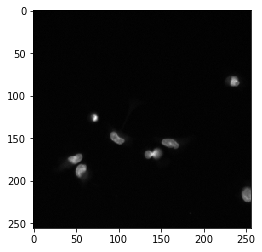

In [12]:
i=15
image = dataloader[ i ]
print(image.shape)
plt.imshow(image[:,:,0], cmap='gray')
plt.show()

In [13]:

def predition( net, image ):    

    #preprosessing 
    image = normalize(image)
    
    image = color.rgb2gray(image)
    image = image[:,:,np.newaxis]

    #froward
    nTiles = 2
    d4a_size = 0

    opts = {
        'n_tiles': nTiles,
        'padding': None, #'mirror',
        'downsampleFactor': 16,
        'padInput': (((d4a_size*2 +2 +2)*2 +2 +2)*2 +2 +2)*2 +2 +2,
        'padOutput': ((((d4a_size -2 -2)*2-2 -2)*2-2 -2)*2-2 -2)*2-2 -2,
        'average_mirror': True
        }

    pred = tiled_forward(net, image, opts )
    return pred

pred = predition(net,image)
print(pred.shape)
print('DONE!!')

>>
>>
(256, 256, 3)
DONE!!


(256, 256, 3)
(256, 256, 3)


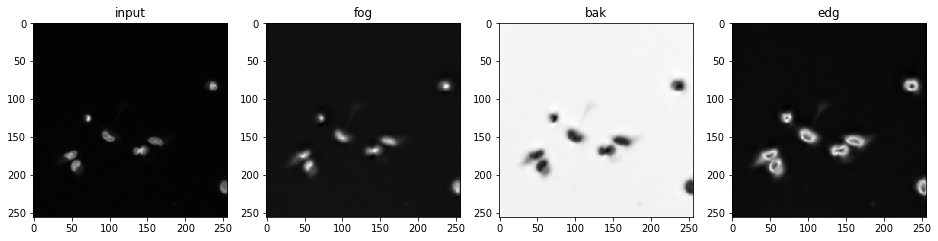

In [14]:
print(pred.shape)
print(image.shape)

plt.figure( figsize=(16,16) )
plt.subplot(141)
plt.imshow( image[:,:,0], cmap='gray' )
plt.title('input')
plt.subplot(142)
plt.imshow( pred[:,:,0], cmap='gray' )
plt.title('fog')
plt.subplot(143)
plt.imshow( pred[:,:,1], cmap='gray' )
plt.title('bak')
plt.subplot(144)
plt.imshow( pred[:,:,2], cmap='gray' )
plt.title('edg')

plt.show()

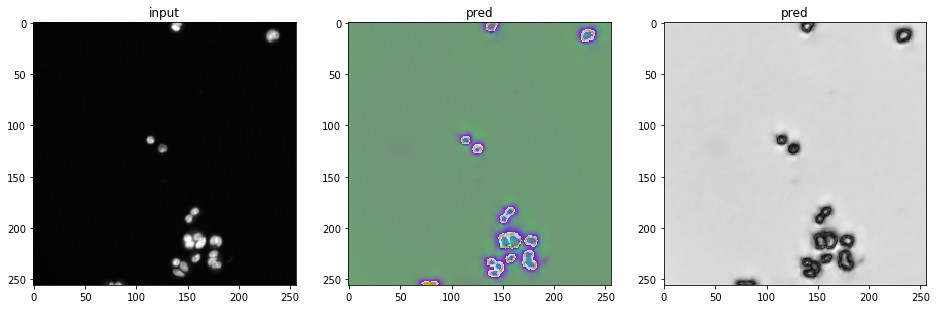

In [166]:
plt.figure( figsize=(16,16) )
plt.subplot(131)
plt.imshow( image[:,:,0], cmap='gray' )
plt.title('input')
plt.subplot(132)
plt.imshow( pred*10 )
plt.title('pred')
plt.subplot(133)
plt.imshow( np.max(pred[:,:,:], axis=2), cmap='gray' )
plt.title('pred')
plt.show()


[0 1]


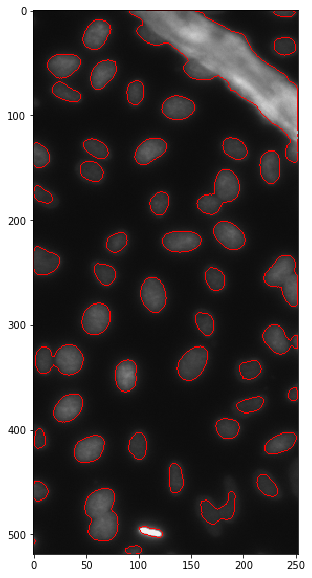

In [257]:


class_data = pred[:,:,:2]

# retain only the top class for each pixel
class_data = np.argmax(class_data, axis=2).astype('uint8')

# remember the classes we found
found_classes = np.unique(class_data)

print(found_classes)


fill_data = np.ndarray((class_data.shape[0], class_data.shape[1], 4), dtype='uint8')
for x in range(3):
    fill_data[:, :, x] = class_data.copy()

# Assuming that class 0 is the background
mask = np.greater(class_data, 0)
fill_data[:, :, 3] = mask * 255
line_data = fill_data.copy()
seg_data = fill_data.copy()

# Black mask of non-segmented pixels
mask_data = np.zeros(fill_data.shape, dtype='uint8')
mask_data[:, :, 3] = (1 - mask) * 255

# Generate outlines around segmented classes
if len(found_classes) > 1:
    
    # Assuming that class 0 is the background.
    line_mask = np.zeros(class_data.shape, dtype=bool)
    max_distance = np.zeros(class_data.shape, dtype=float) + 1
    for c in (x for x in found_classes if x != 0):
        
        c_mask = np.equal(class_data, c)
        # Find the signed distance from the zero contour
        distance = skfmm.distance(c_mask.astype('float32') - 0.5)
        # Accumulate the mask for all classes
        line_width = 1
        line_mask |= c_mask & np.less(distance, line_width)
        max_distance = np.maximum(max_distance, distance + 128)

        line_data[:, :, 3] = line_mask * 255
        max_distance = np.maximum(max_distance, np.zeros(max_distance.shape, dtype=float))
        max_distance = np.minimum(max_distance, np.zeros(max_distance.shape, dtype=float) + 255)
        seg_data[:, :, 3] = max_distance


        
image_sh = image.copy()
image_sh[line_mask,:] = [255,0,0];
        
plt.figure(figsize=(10, 10))
plt.imshow(image_sh)
plt.show()

# Pos processing

In [168]:
def showimagelist( mask, edges ):
    
    plt.figure( figsize=(16,16) )
    plt.subplot(121)
    plt.imshow( mask   )
    plt.title('a')
    plt.subplot(122)
    plt.imshow( edges  )
    plt.title('b')
    plt.show()
    
def showimage( image ):
    plt.figure( figsize=(8,8) )
    plt.imshow( image )
    plt.show()
    

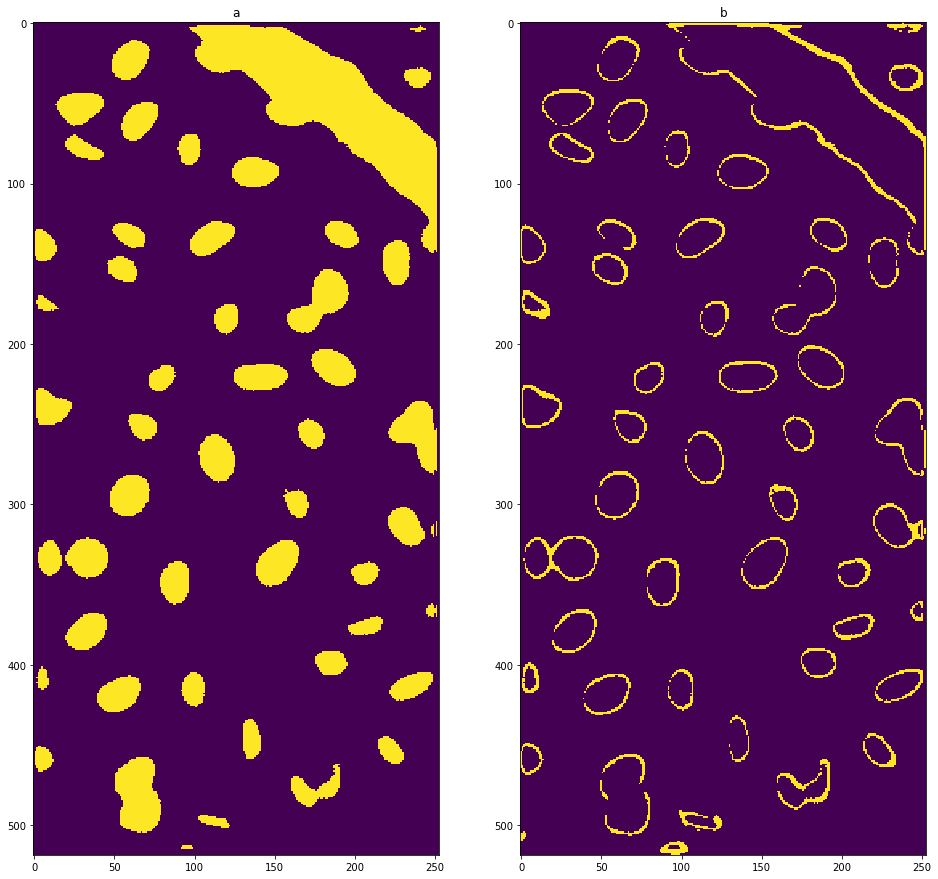

In [187]:

class_data = pred
class_data = np.argmax(class_data, axis=2).astype('uint8')
mask_bak = (class_data==0)
mask_fog = (class_data==1)
mask_edg = (class_data==2)

showimagelist( mask_bak, mask_edg )



# Kaggle posprocessing 
- https://www.kaggle.com/jakubczakon/morphological-postprocessing-on-unet-lb-0-429

## Aproch 1

In [170]:
import skimage.morphology as morph
from skimage.filters import threshold_otsu
import scipy.ndimage as ndi
from scipy.stats import itemfreq
from skimage.color import label2rgb

In [171]:
def mean_blob_size(mask):
    
    labels, labels_nr = ndi.label(mask)
    if labels_nr < 2:
        mean_area = 1
        mean_radius = 1
    else:
        mean_area = int(itemfreq(labels)[1:, 1].mean())
        mean_radius = int(np.round(np.sqrt(mean_area) / np.pi))
    return mean_area, mean_radius

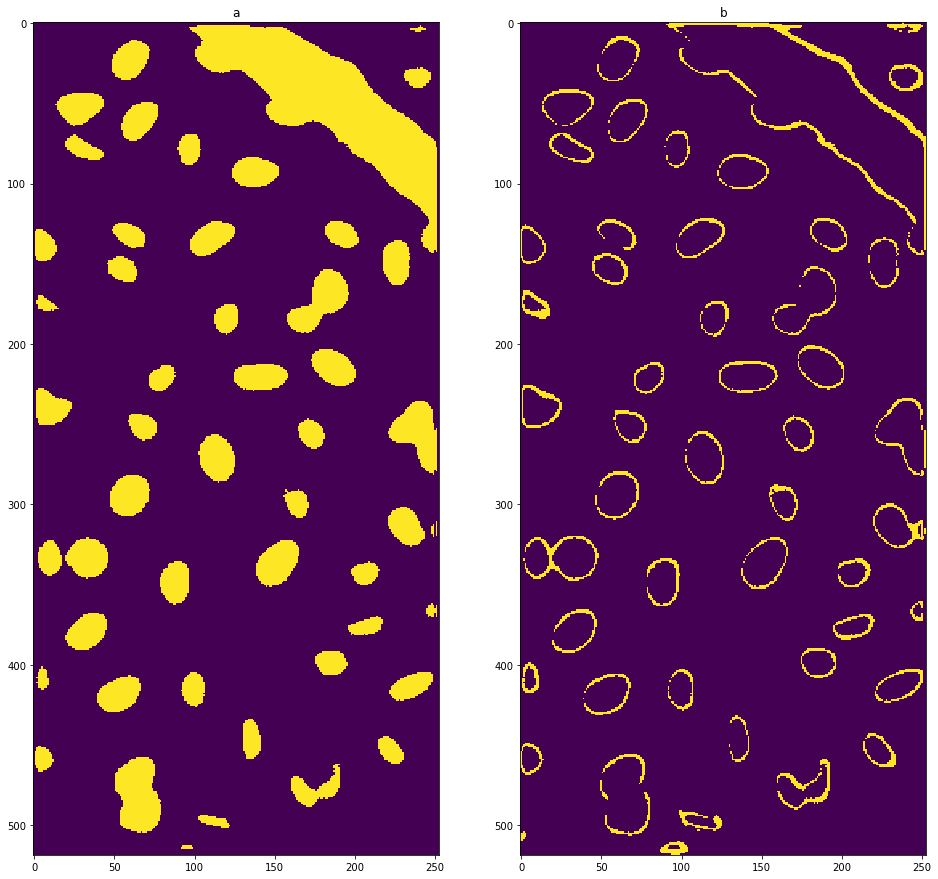

In [188]:
m, c = mask_bak, mask_edg
showimagelist( m, c )

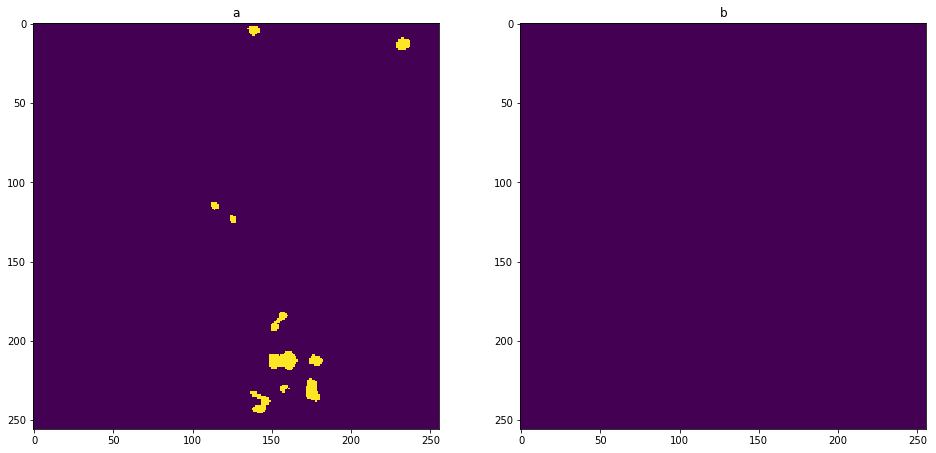

In [175]:
# Pipeline v1
def clean_mask_v1( m_b, c_b ):
    m_bb = np.where(m_b | c_b, 1, 0)    
    m_bb = ndi.binary_fill_holes(m_bb)
    m_bb = np.where(c_b & (~m_b), 0, m_bb)
    area, radius = mean_blob_size( m_b )
    m_bb = morph.binary_opening(m_bb, selem=morph.disk(0.25*radius))    
    return m_bb


m_bb = clean_mask_v1( m, c )
showimagelist(m, m_bb )

## Aproch 2

In [176]:
def pad_mask(mask, pad):
    if pad <= 1: pad = 2
    h, w = mask.shape
    h_pad = h + 2 * pad
    w_pad = w + 2 * pad
    mask_padded = np.zeros((h_pad, w_pad))
    mask_padded[pad:pad + h, pad:pad + w] = mask
    mask_padded[pad - 1, :] = 1
    mask_padded[pad + h + 1, :] = 1
    mask_padded[:, pad - 1] = 1
    mask_padded[:, pad + w + 1] = 1

    return mask_padded

def crop_mask(mask, crop):
    if crop <= 1: crop = 2
    h, w = mask.shape
    mask_cropped = mask[crop:h - crop, crop:w - crop]
    return mask_cropped

def drop_artifacts(mask_after, mask_pre, min_coverage=0.5):
    connected, nr_connected = ndi.label(mask_after)
    mask = np.zeros_like(mask_after)
    for i in range(1, nr_connected + 1):
        conn_blob = np.where(connected == i, 1, 0)
        initial_space = np.where(connected == i, mask_pre, 0)
        blob_size = np.sum(conn_blob)
        initial_blob_size = np.sum(initial_space)
        coverage = float(initial_blob_size) / float(blob_size)
        if coverage > min_coverage:
            mask = mask + conn_blob
        else:
            mask = mask + initial_space
    return mask



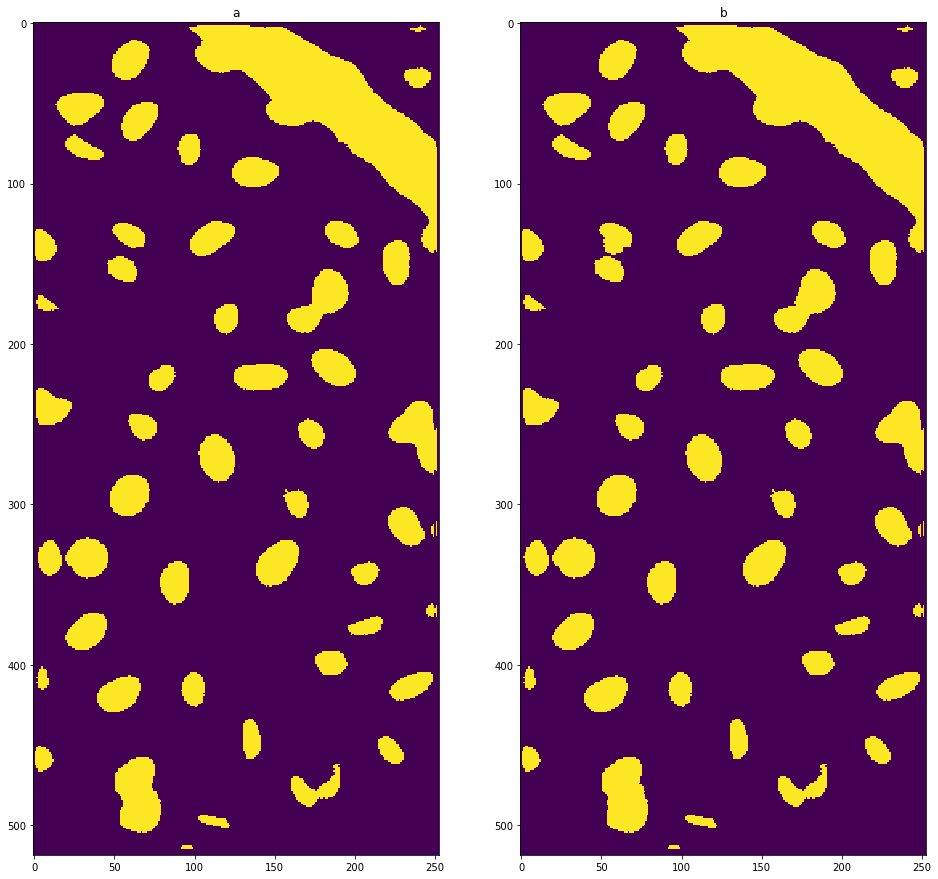

In [252]:

def clean_mask_v2(m_b,c_b):


    # combine contours and masks and fill the cells
    m_bb = np.where(m_b | c_b, 1, 0)
    m_bb = ndi.binary_fill_holes(m_bb)

    # close what wasn't closed before 
    area, radius = mean_blob_size(m_b)
    struct_size = int(1.25*radius)
    struct_el = morph.disk(struct_size)
    m_padded = pad_mask(m_bb, pad=struct_size)
    m_padded = morph.binary_closing(m_padded, selem=struct_el)
    m_bb = crop_mask(m_padded, crop=struct_size)

    m_bb = np.where(c_b & (~m_b), 0, m_bb)

    area, radius = mean_blob_size(m_b)
    struct_size = int(0.75*radius)
    struct_el = morph.disk(struct_size)
    m_padded = pad_mask(m_bb, pad=struct_size)
    m_padded = morph.binary_opening(m_padded, selem=struct_el)
    m_bb = crop_mask(m_padded, crop=struct_size)

    # join the connected cells with what we had at the beginning
    m_bb = np.where(m_b|m_bb,1,0)
    m_bb = ndi.binary_fill_holes(m_bb)

    m_bb = drop_artifacts(m_bb, m_b,min_coverage=0.25)
    
    return m_bb


m, c = mask_bak, mask_edg
m_bb = clean_mask_v2(m,c)
#m_bb,cont = ndi.label(m_bb) 

showimagelist(m, m_bb)


## Aproch 3

In [271]:

def good_markers_v1(m_b,c_b):    
    mk_ = np.where(c_b,0,m_b)
    return mk_

def good_markers_v2(m_b,c_b):   
    mk_ = np.where(c_b,0,m_b)
    return mk_

def good_markers_v3(m_b,c_b):   
    mk_ = np.where(c_b,0,m_b)    
    area, radius = mean_blob_size(m_b)
    struct_size = int(0.25*radius)
    struct_el = morph.disk(struct_size)
    m_padded = pad_mask(mk_, pad=struct_size)
    m_padded = morph.erosion(m_padded, selem=struct_el)
    mk_ = crop_mask(m_padded, crop=struct_size)
    mk_,_ = ndi.label(mk_) 
    return mk_

def good_distance_v1(m_b):
    distance = ndi.distance_transform_edt(m_b)
    return distance

def watershed_v1(mask, contour):
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)    
    water = morph.watershed(-good_distance, good_markers, mask=cleaned_mask)
    return water


def add_dropped_water_blobs(water, mask_cleaned):
    water_mask = (water > 0).astype(np.uint8)
    dropped = mask_cleaned - water_mask
    dropped, _ = ndi.label(dropped)
    dropped = np.where(dropped, dropped + water.max(), 0)
    water = water + dropped
    return water

def drop_artifacts_per_label(labels, initial_mask):
    labels_cleaned = np.zeros_like(labels)
    for i in range(1, labels.max() + 1):
        component = np.where(labels == i, 1, 0)
        component_initial_mask = np.where(labels == i, initial_mask, 0)
        component = drop_artifacts(component, component_initial_mask)
        labels_cleaned = labels_cleaned + component * i
    return labels_cleaned

def watershed_v2(mask, contour):
    
    #cleaned_mask = clean_mask_v2(mask, contour)
    cleaned_mask = mask    
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)    
    water = morph.watershed(-good_distance, good_markers, mask=cleaned_mask)    
    water = add_dropped_water_blobs(water, cleaned_mask)    
    m_thresh = threshold_otsu(mask)
    initial_mask_binary = (mask > m_thresh).astype(np.uint8)    
    water = drop_artifacts_per_label(water,initial_mask_binary)    
    return water


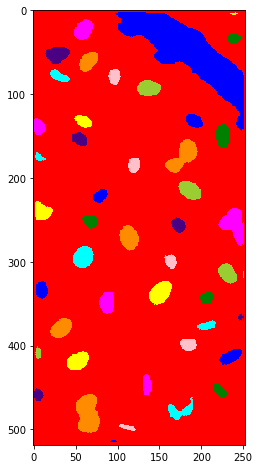

In [272]:

m, c = mask_bak, mask_edg
water = watershed_v2(m, c)
water = label2rgb(water)
showimage(water)


In [180]:
from itertools import product

def relabel(img):
    h, w = img.shape

    relabel_dict = {}

    for i, k in enumerate(np.unique(img)):
        if k == 0:
            relabel_dict[k] = 0
        else:
            relabel_dict[k] = i
    for i, j in product(range(h), range(w)):
        img[i, j] = relabel_dict[img[i, j]]
    return img

def drop_small(img, min_size):
    img = morph.remove_small_objects(img, min_size=min_size)
    return relabel(img)

def fill_holes_per_blob(image):
    image_cleaned = np.zeros_like(image)
    for i in range(1, image.max() + 1):
        mask = np.where(image == i, 1, 0)
        mask = ndi.morphology.binary_fill_holes(mask)
        image_cleaned = image_cleaned + mask * i
    return image_cleaned

In [273]:
def watershed_v3(mask, contour):
    
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    labels = morph.watershed(-good_distance, good_markers, mask=cleaned_mask)    
    labels = add_dropped_water_blobs(labels, cleaned_mask)
    
    m_thresh = threshold_otsu(mask)
    initial_mask_binary = (mask > m_thresh).astype(np.uint8)  
    
    labels = drop_artifacts_per_label(labels,initial_mask_binary)
    
    labels = drop_small(labels, min_size=20)
    labels = fill_holes_per_blob(labels)
        
    return labels

11


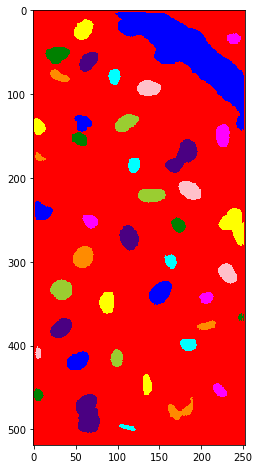

In [274]:
m, c = mask_bak, mask_edg
label = watershed_v3(m, c)
print( len(np.unique(water)) ) 

labelcolor = label2rgb(label)
showimage(labelcolor)

# Create submission 

In [21]:
from itertools import product
import skimage.morphology as morph
from skimage.filters import threshold_otsu
import scipy.ndimage as ndi
from scipy.stats import itemfreq
from skimage.color import label2rgb

In [34]:
def showimagelist( mask, edges ):
    
    plt.figure( figsize=(16,16) )
    plt.subplot(121)
    plt.imshow( mask   )
    plt.title('a')
    plt.subplot(122)
    plt.imshow( edges  )
    plt.title('b')
    plt.show()
    
def showimage( image ):
    plt.figure( figsize=(8,8) )
    plt.imshow( image )
    plt.show()

def pad_mask(mask, pad):
    if pad <= 1: pad = 2
    h, w = mask.shape
    h_pad = h + 2 * pad
    w_pad = w + 2 * pad
    mask_padded = np.zeros((h_pad, w_pad))
    mask_padded[pad:pad + h, pad:pad + w] = mask
    mask_padded[pad - 1, :] = 1
    mask_padded[pad + h + 1, :] = 1
    mask_padded[:, pad - 1] = 1
    mask_padded[:, pad + w + 1] = 1

    return mask_padded

def drop_artifacts_per_label(labels, initial_mask):
    labels_cleaned = np.zeros_like(labels)
    for i in range(1, labels.max() + 1):
        component = np.where(labels == i, 1, 0)
        component_initial_mask = np.where(labels == i, initial_mask, 0)
        component = drop_artifacts(component, component_initial_mask)
        labels_cleaned = labels_cleaned + component * i
    return labels_cleaned

def mean_blob_size(mask):
    
    labels, labels_nr = ndi.label(mask)
    if labels_nr < 2:
        mean_area = 1
        mean_radius = 1
    else:
        mean_area = int(itemfreq(labels)[1:, 1].mean())
        mean_radius = int(np.round(np.sqrt(mean_area) / np.pi))
    return mean_area, mean_radius

def crop_mask(mask, crop):
    if crop <= 1: crop = 2
    h, w = mask.shape
    mask_cropped = mask[crop:h - crop, crop:w - crop]
    return mask_cropped

def drop_artifacts(mask_after, mask_pre, min_coverage=0.5):
    connected, nr_connected = ndi.label(mask_after)
    mask = np.zeros_like(mask_after)
    for i in range(1, nr_connected + 1):
        conn_blob = np.where(connected == i, 1, 0)
        initial_space = np.where(connected == i, mask_pre, 0)
        blob_size = np.sum(conn_blob)
        initial_blob_size = np.sum(initial_space)
        coverage = float(initial_blob_size) / float(blob_size)
        if coverage > min_coverage:
            mask = mask + conn_blob
        else:
            mask = mask + initial_space
    return mask
    
def relabel(img):
    h, w = img.shape

    relabel_dict = {}

    for i, k in enumerate(np.unique(img)):
        if k == 0:
            relabel_dict[k] = 0
        else:
            relabel_dict[k] = i
    for i, j in product(range(h), range(w)):
        img[i, j] = relabel_dict[img[i, j]]
    return img

def drop_small(img, min_size):
    img = morph.remove_small_objects(img, min_size=min_size)
    return relabel(img)

def fill_holes_per_blob(image):
    image_cleaned = np.zeros_like(image)
    for i in range(1, image.max() + 1):
        mask = np.where(image == i, 1, 0)
        mask = ndi.morphology.binary_fill_holes(mask)
        image_cleaned = image_cleaned + mask * i
    return image_cleaned
    
def decompose(labeled):
    nr_true = labeled.max()
    masks = []
    for i in range(1, nr_true + 1):
        msk = labeled.copy()
        msk[msk != i] = 0.
        msk[msk == i] = 255.
        masks.append(msk)
    if not masks: return np.array([labeled])
    else: return np.array(masks)
    
def getlabel(mask):
    labeled, nr_true = ndi.label(mask)
    return labeled







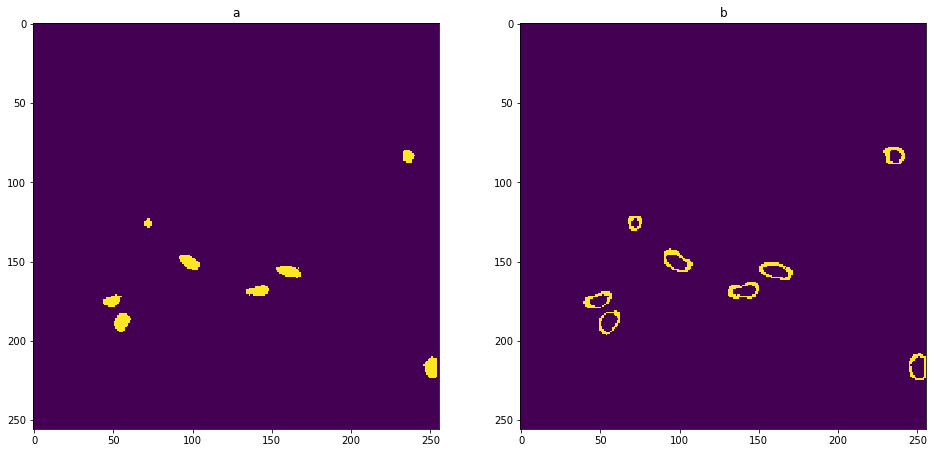

In [28]:
class_data = pred
class_data = np.argmax(class_data, axis=2).astype('uint8')
mask_bak = (class_data==0)
mask_fog = (class_data==1)
mask_edg = (class_data==2)

showimagelist( mask_bak, mask_edg )

0 255 (256, 256, 8)
10 255 (256, 256, 3)


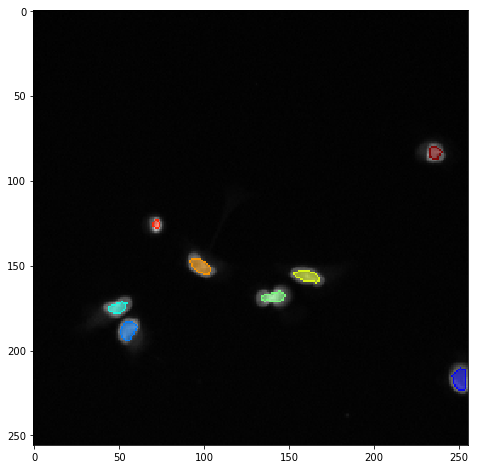

In [33]:


m, f, c = mask_bak, mask_fog, mask_edg

labels = getlabel(m)
labels = drop_artifacts_per_label(labels, m)
labels = drop_small(labels, min_size=20)
labels = fill_holes_per_blob(labels)
labels = np.transpose( decompose(labels), (1,2,0) )

summary(labels)
summary(image)

imagecell = view.makeimagecell(image, labels, alphaback=0.5, alphaedge=0.9)

showimage(imagecell)